<img src="tic3151.png" style="height: 70px; width: 200px" align=left> 
<img src="logo-MMU.png" style="height: 70px; width: 200px" align=right> 

### Team members

Ahmad Ayaan - 1191302794 

Salah Fayeq y. AlHaismawi - 1201303035

Aisha Sakinah Binti Saadon - 1191101867

Aryssa Amanda Binti Azhar - 1191100575


### The assignment contains following questions


# Installing Libraries

##### Note: Uncomment the code the code to install the relevant libraries

In [59]:
# pip install matplotlib.pyplot
# pip install ortools
# pip install pulp

SyntaxError: invalid syntax (<ipython-input-59-54c4d1f45157>, line 2)

# Importing Libraries

In [77]:
from random import randint
import random
from tabulate import tabulate
import matplotlib.pyplot as plt
import constraint
import pulp
from ortools.sat.python import cp_model

# Question 1

Year-end school holiday is coming soon. A kindergarten teacher would like to give each
of the student in her class, an amazing holiday set by November 2023. There are 25
students in her class consisting of 15 girls and 10 boys. She has approached you for
help and provided the following details to you:

• Budget for 25 holiday sets = RM 200.00

• Each holiday set must be wrapped using a sheet of paper i.e. blue wrapper for
boy’s holiday set and pink wrapper for girl’s holiday set. Each wrapper cost
RM1.00

• Each holiday set should have at least 2 items being stationery



## Variables Declaration

In [3]:
# Constant variables
budget = 200.00
minimum_stationary_item = 2
wrapper_cost = 1.00

# List of items and their prices
items = [
    ("Chipsmore Biscuit", 2.00),
    ("2B pencil", 1.00),
    ("Color pencil", 3.00),
    ("Magic pen", 3.00),
    ("Potato chip", 2.00),
    ("Milo packet", 1.00),
    ("Mini sketch book", 2.00),
    ("Milk biscuit", 3.00)
]

mutation_rate = 0.1
wrapper_cost = 1 * 25  # Wrapper cost for 25 sets

## Population and Individuals



In [4]:
def individuals():
    return [random.randint(0, 1) for items in range(len(items))]

def generate_population(population_size):
    return [individuals() for x in range(population_size)]

## Fitness Function

The fitness function calculates the total cost of items in a chromosome, after deducting the cost of wrappers and ensuring that atleast 2 of the items are stationery.

In [5]:
def fitness_function(chromosome):
    total = 0
    num_stationery_items = 0
    num_items = 0
    for i, j in enumerate(chromosome):
        if j == 1:
            # to calculate the total cost of the items present in the set
            total += items[i][1]
            num_items += 1
            # to check if the current sets have stationery
            if items[i][0] in ["2B pencil", "Color pencil", "Magic pen", "Mini sketch book"]:
                num_stationery_items += 1

    if num_stationery_items >= 2 and (total*25) + wrapper_cost <=budget:
         # Calculate the fitness score based on the weighted sum of total cost and number of items
        total_score = total * num_items
        items_score = num_items * 10
        score = total_score + items_score
        #print(score)
        return score
    else:
        return 0 if total <= 200 else -1

## Selection Function

In [6]:
"""Perform selection using roulette wheel selection."""
def selection_roulette_wheel(population, fitness_values):
    total_fitness = sum(fitness_values)
    if total_fitness == 0:
        probabilities = [1 / len(population)] * len(population)
    else:
        probabilities = [fitness / total_fitness for fitness in fitness_values]
    selected = random.choices(population, weights=probabilities, k=2)
    return selected[0], selected[1]


"""Perform selection using rank selection."""
def selection_rank(population, fitness_values):
    ranked_population = sorted(zip(population, fitness_values), key=lambda x: x[1], reverse=True)
    selected = []
    while len(selected) < 2:
        for chromosome, fitness in ranked_population:
            if fitness > 0:  # Select only individuals with positive fitness
                selected.append(chromosome.copy())
                if len(selected) == 2:
                    break
    return selected[0], selected[1]


## Crossover Function

In [7]:
"""Perform crossover using single point crossover."""
def crossover_single_point(parent1, parent2):
    single_point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:single_point] + parent2[single_point:]
    child2 = parent2[:single_point] + parent1[single_point:]
    return child1, child2

"""Perform crossover using two point crossover."""
def crossover_two_point(parent1, parent2):
    two_point = sorted(random.sample(range(len(parent1)), 2))
    child1 = parent1[:two_point[0]] + parent2[two_point[0]:two_point[1]] + parent1[two_point[1]:]
    child2 = parent2[:two_point[0]] + parent1[two_point[0]:two_point[1]] + parent2[two_point[1]:]
    return child1, child2

## Mutation Function

In [8]:
"""Perform inversion mutation."""
def mutation_inversion(chromosome):
    start = random.randint(0, len(chromosome) - 1)
    end = random.randint(start + 1, len(chromosome))
    mutated_chromosome = chromosome[:start] + chromosome[start:end][::-1] + chromosome[end:]
    return mutated_chromosome

"""Perform bit flipping mutation."""
def mutation_bit_flip(chromosome):
    mutated_chromosome = chromosome[:]
    for i in range(len(mutated_chromosome)):
        if random.random() < mutation_rate:
            mutated_chromosome[i] = 1 - mutated_chromosome[i]
    return mutated_chromosome

## Main Function

In [9]:
def evolve(population, fitness_values, selection_method, crossover_method, mutation_method):
    next_generation = []
    while len(next_generation) < 25:
        parent1, parent2 = selection_method(population, fitness_values)
        #print(parent1, parent2)
        offspring1, offspring2 = crossover_method(parent1, parent2)
        #print(offspring1, offspring2)
        offspring1 = mutation_method(offspring1)
        offspring2 = mutation_method(offspring2)
        next_generation.extend([offspring1, offspring2])
        #print(next_generation)
    return next_generation[:25]


In [10]:
def main(selection_method, crossover_method, mutation_method):
    # Generate an initial population
    population = generate_population(25)
    
    # Calculate fitness values for each chromosome
    fitness_values = [fitness_function(chromosome) for chromosome in population]
    fitness_history = []

    best_fitness = float('inf')
    best_combination = []

    for generation in range(100):
        # Select parents and perform crossover and mutation
        population = evolve(population, fitness_values, selection_method, crossover_method, mutation_method)

        # Calculate fitness values for each chromosome
        fitness_values = [fitness_function(chromosome) for chromosome in population]
        fitness_history.append(max(fitness_values))

       # Find the best fitness value and corresponding combination
    best_fitness = max(fitness_values)
    best_combination = population[fitness_values.index(best_fitness)].copy()


    # Display the total combination and the content of the combination
    print("Total Combination of Items: ")
    total_combination = sum(best_combination)
    print(total_combination)

    print("Content of the Combination of Items:")
    selected_items = []
    unit_price = 0
    for i, item in enumerate(best_combination):
        if item == 1:
            item_name = items[i][0]
            item_price = items[i][1]
            unit_price += item_price
            selected_items.append([item_name, item_price])
            
    selected_items.append(['Wrapper cost', '1'])
    unit_price +=1
    print(tabulate(selected_items, headers=["Item Name", "Price (RM)"], tablefmt="grid"))

    print("Unit Price: ")
    print(unit_price if best_fitness >= 0 else 0)
    
    print("Total Price: ")
    print(unit_price * 25 if best_fitness >= 0 else 0)
    
    return best_combination, fitness_history


## Perfomance Assessment



In [11]:
# Test 1
print("Best holiday set (Selection Method: Ranked, Crossover Method: Single Point, Mutation Method: Inversion):")
print()
best_holiday_set_1, fitness_history_1 = main(selection_roulette_wheel, crossover_two_point, mutation_bit_flip)

Best holiday set (Selection Method: Ranked, Crossover Method: Single Point, Mutation Method: Inversion):

Total Combination of Items: 
4
Content of the Combination of Items:
+-------------------+--------------+
| Item Name         |   Price (RM) |
+===================+==============+
| Chipsmore Biscuit |            2 |
+-------------------+--------------+
| 2B pencil         |            1 |
+-------------------+--------------+
| Color pencil      |            3 |
+-------------------+--------------+
| Milo packet       |            1 |
+-------------------+--------------+
| Wrapper cost      |            1 |
+-------------------+--------------+
Unit Price: 
8.0
Total Price: 
200.0


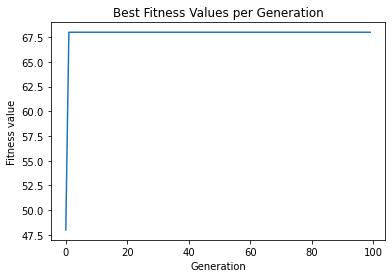

In [12]:
x = range(0,len(fitness_history_1))
y = fitness_history_1

plt.plot(x, y)

plt.title("Best Fitness Values per Generation")
plt.xlabel("Generation")
plt.ylabel("Fitness value")

plt.show()

## Summary


# Question 2



## OrTools Library

In [82]:
slots = [1, 2, 3, 4, 5, 6]
# Define the teams, days, and slots
teams = [1, 2, 3, 4, 5, 6, 7]
days = [1, 2, 3, 4]
def solve_dodol_feast():



    # Create the CP-SAT model
    model = cp_model.CpModel()

    # Create the decision variables
    variables = {}
    for day in days:
        for slot in slots:
            for team in teams:
                variables[(day, slot, team)] = model.NewBoolVar(f'time_{team}_{day}_{slot}')

    # Constraint 1: Each team must stir the pot for at least 8 hours during the feast
    for team in teams:
        model.Add(sum(variables[(day, slot, team)] for day in days for slot in slots) >= 2)

    # Constraint 2: No team should stir the pot for more than 4 hours a day
    for day in days:
        for team in teams:
            model.Add(sum(variables[(day, slot, team)] for slot in slots) <= 1)

    # Constraint 3: No team should stir the pot consecutively
    for day in days:
        for slot in slots[1:]:
            for team in teams:
                model.Add(variables[(day, slot, team)] <= sum(variables[(day, slot - 1, t)] for t in teams if t != team))

    # Constraint 4: Only one team should stir the pot in each time slot
    for day in days:
        for slot in slots:
            model.Add(sum(variables[(day, slot, team)] for team in teams) == 1)

    # Create the objective variable
    objective_var = model.NewIntVar(0, len(days) * len(slots) * len(teams), 'objective')

    # Constraint 5: Minimize the total number of team assignments
    model.Add(objective_var == sum(variables[(day, slot, team)] for day in days for slot in slots for team in teams))

    # Set the objective function
    model.Minimize(objective_var)

    # Create the solver and solve the model
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = True
    status = solver.Solve(model)

    # Check if a solution is found
    if status != cp_model.OPTIMAL:
        print("No feasible solution found.")
        return None

    # Extract the solution
    solution = {}
    for day in days:
        for slot in slots:
            for team in teams:
                if solver.BooleanValue(variables[(day, slot, team)]):
                    solution[(day, slot)] = team
                    
    return solution

# Solve the dodol feast problem
solution = solve_dodol_feast()

# Print the solution
if solution:
    # Create a table to display the feast schedule
    table = []
    for day in days:
        row = [f"Day {day}"]
        for slot in slots:
            team = solution.get((day, slot), "-")
            row.append(f"Team {team}")
        table.append(row)

    # Display the feast schedule table
    headers = [""] + [f"Time Slot {slot}" for slot in slots]
    print("Feast schedule:")
    print(tabulate(table, headers=headers, showindex=False, tablefmt="grid"))


Feast schedule:
+-------+---------------+---------------+---------------+---------------+---------------+---------------+
|       | Time Slot 1   | Time Slot 2   | Time Slot 3   | Time Slot 4   | Time Slot 5   | Time Slot 6   |
+=======+===============+===============+===============+===============+===============+===============+
| Day 1 | Team 7        | Team 1        | Team 3        | Team 4        | Team 6        | Team 5        |
+-------+---------------+---------------+---------------+---------------+---------------+---------------+
| Day 2 | Team 5        | Team 4        | Team 6        | Team 2        | Team 1        | Team 7        |
+-------+---------------+---------------+---------------+---------------+---------------+---------------+
| Day 3 | Team 6        | Team 3        | Team 4        | Team 2        | Team 1        | Team 5        |
+-------+---------------+---------------+---------------+---------------+---------------+---------------+
| Day 4 | Team 7        | Team

## Pulp Library

In [76]:
# Create a problem instance
problem = pulp.LpProblem("DodolFeast", pulp.LpMinimize)

# Define the variables and domains
teams = [1, 2, 3, 4, 5, 6, 7]
days = [1, 2, 3, 4]
time_slots = [1, 2, 3, 4, 5, 6]

# Define the decision variables
x = pulp.LpVariable.dicts("TeamAssignment", (days, time_slots, teams), cat="Binary")

# Define the constraints
for day in days:
    # Constraint 1: Each team stirs the pot of dodol for four hours at a time
    for time_slot in time_slots:
        problem += pulp.lpSum(x[day][time_slot][team] for team in teams) == 1

for time_slot in time_slots:
    # Constraint 2: No team stirs the pot of dodol for more than four hours a day
    for day in days:
        problem += pulp.lpSum(x[day][time_slot][team] for team in teams) <= 1

# Constraint 3: Each team stirs the pot of dodol for at least 2 slots during the entire feast
for team in teams:
    problem += pulp.lpSum(x[day][time_slot][team] for day in days for time_slot in time_slots) >= 2

# Constraint 4: No team can be assigned to multiple time slots on the same day
for day in days:
    for team in teams:
        problem += pulp.lpSum(x[day][time_slot][team] for time_slot in time_slots) <= 1

# Solve the problem
problem.solve()

# Create a table to display the duty rosters
table = []
for day in days:
    row = [f"Day {day}"]
    for time_slot in time_slots:
        team_assigned = [f"Team {team}" for team in teams if pulp.value(x[day][time_slot][team]) == 1]
        row.append(", ".join(team_assigned))
    table.append(row)

# Display the duty rosters table
headers = [""] + [f"Time Slot {ts}" for ts in time_slots]
print("Feast schedule:")
print(tabulate(table, headers=headers, showindex=False, tablefmt="grid"))


Feast schedule:
+-------+---------------+---------------+---------------+---------------+---------------+---------------+
|       | Time Slot 1   | Time Slot 2   | Time Slot 3   | Time Slot 4   | Time Slot 5   | Time Slot 6   |
+=======+===============+===============+===============+===============+===============+===============+
| Day 1 | Team 1        | Team 3        | Team 4        | Team 5        | Team 7        | Team 6        |
+-------+---------------+---------------+---------------+---------------+---------------+---------------+
| Day 2 | Team 7        | Team 6        | Team 3        | Team 5        | Team 4        | Team 1        |
+-------+---------------+---------------+---------------+---------------+---------------+---------------+
| Day 3 | Team 4        | Team 7        | Team 3        | Team 2        | Team 5        | Team 1        |
+-------+---------------+---------------+---------------+---------------+---------------+---------------+
| Day 4 | Team 6        | Team

## Summary

# Question 3


### Player list

In [1]:
import pandas as pd
import numpy as np

# Load data
playerlist = pd.read_csv("Question-3-Dataset/NBA-playerlist.csv")
playerlist 

,Unnamed: 0,DISPLAY_FIRST_LAST,DISPLAY_LAST_COMMA_FIRST,FROM_YEAR,GAMES_PLAYED_FLAG,OTHERLEAGUE_EXPERIENCE_CH,PERSON_ID,PLAYERCODE,ROSTERSTATUS,TEAM_ABBREVIATION,TEAM_CITY,TEAM_CODE,TEAM_ID,TEAM_NAME,TO_YEAR
0,0,Alaa Abdelnaby,"Abdelnaby, Alaa",1990,Y,0,76001,HISTADD_alaa_abdelnaby,0,NaN,NaN,NaN,0,NaN,1994
1,1,Zaid Abdul-Aziz,"Abdul-Aziz, Zaid",1968,Y,0,76002,HISTADD_zaid_abdul-aziz,0,NaN,NaN,NaN,0,NaN,1977
2,2,Kareem Abdul-Jabbar,"Abdul-Jabbar, Kareem",1969,Y,0,76003,HISTADD_kareem_abdul-jabbar,0,NaN,NaN,NaN,0,NaN,1988
3,3,Mahmoud Abdul-Rauf,"Abdul-Rauf, Mahmoud",1990,Y,0,51,mahmoud_abdul-rauf,0,NaN,NaN,NaN,0,NaN,2000
4,4,Tariq Abdul-Wahad,"Abdul-Wahad, Tariq",1997,Y,0,1505,tariq_abdul-wahad,0,NaN,NaN,NaN,0,NaN,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4388,4388,Ante Zizic,"Zizic, Ante",2017,Y,1,1627790,ante_zizic,0,NaN,NaN,NaN,0,NaN,2018
4389,4389,Jim Zoet,"Zoet, Jim",1982,Y,0,78647,HISTADD_jim_zoet,0,NaN,NaN,NaN,0,NaN,1982
4390,4390,Bill Zopf,"Zopf, Bill",1970,Y,0,78648,HISTADD_zip_zopf,0,NaN,NaN,NaN,0,NaN,1970
4391,4391,Ivica Zubac,"Zubac, Ivica",2016,Y,1,1627826,ivica_zubac,0,NaN,NaN,NaN,0,NaN,2018


In [2]:
# Drop unnecessary columns
playerlist = playerlist.drop(['Unnamed: 0', 'DISPLAY_LAST_COMMA_FIRST'], axis=1)
playerlist = playerlist.rename(columns={'DISPLAY_FIRST_LAST': 'PLAYER_NAME'})

# Rearrange the columns
person_id_col = playerlist.pop('PERSON_ID')  # Remove 'PERSON_ID' column from DataFrame
playerlist.insert(0, 'PERSON_ID', person_id_col)  # Insert 'PERSON_ID' column at the front

# Display data
playerlist

,PERSON_ID,PLAYER_NAME,FROM_YEAR,GAMES_PLAYED_FLAG,OTHERLEAGUE_EXPERIENCE_CH,PLAYERCODE,ROSTERSTATUS,TEAM_ABBREVIATION,TEAM_CITY,TEAM_CODE,TEAM_ID,TEAM_NAME,TO_YEAR
0,76001,Alaa Abdelnaby,1990,Y,0,HISTADD_alaa_abdelnaby,0,NaN,NaN,NaN,0,NaN,1994
1,76002,Zaid Abdul-Aziz,1968,Y,0,HISTADD_zaid_abdul-aziz,0,NaN,NaN,NaN,0,NaN,1977
2,76003,Kareem Abdul-Jabbar,1969,Y,0,HISTADD_kareem_abdul-jabbar,0,NaN,NaN,NaN,0,NaN,1988
3,51,Mahmoud Abdul-Rauf,1990,Y,0,mahmoud_abdul-rauf,0,NaN,NaN,NaN,0,NaN,2000
4,1505,Tariq Abdul-Wahad,1997,Y,0,tariq_abdul-wahad,0,NaN,NaN,NaN,0,NaN,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4388,1627790,Ante Zizic,2017,Y,1,ante_zizic,0,NaN,NaN,NaN,0,NaN,2018
4389,78647,Jim Zoet,1982,Y,0,HISTADD_jim_zoet,0,NaN,NaN,NaN,0,NaN,1982
4390,78648,Bill Zopf,1970,Y,0,HISTADD_zip_zopf,0,NaN,NaN,NaN,0,NaN,1970
4391,1627826,Ivica Zubac,2016,Y,1,ivica_zubac,0,NaN,NaN,NaN,0,NaN,2018


In [3]:
# Check data types
print(playerlist.columns)
playerlist.dtypes

Index(['PERSON_ID', 'PLAYER_NAME', 'FROM_YEAR', 'GAMES_PLAYED_FLAG',
       'OTHERLEAGUE_EXPERIENCE_CH', 'PLAYERCODE', 'ROSTERSTATUS',
       'TEAM_ABBREVIATION', 'TEAM_CITY', 'TEAM_CODE', 'TEAM_ID', 'TEAM_NAME',
       'TO_YEAR'],
      dtype='object')


PERSON_ID                     int64
PLAYER_NAME                  object
FROM_YEAR                     int64
GAMES_PLAYED_FLAG            object
OTHERLEAGUE_EXPERIENCE_CH     int64
PLAYERCODE                   object
ROSTERSTATUS                  int64
TEAM_ABBREVIATION            object
TEAM_CITY                    object
TEAM_CODE                    object
TEAM_ID                       int64
TEAM_NAME                    object
TO_YEAR                       int64
dtype: object

<b> Handle duplicates and missing values

In [4]:
def check_duplicates(data):
    duplicate_rows = data[data.duplicated()]
    print("Duplicate Rows:", len(duplicate_rows))
    
    if len(duplicate_rows) > 0:
        data.drop_duplicates(inplace=True)
        print("Duplicate rows dropped.")
        
def check_missing_values(data):
    has_missing_values = False  # Flag variable

    for column in data.columns:
        null_val = data[column].isna().sum()
        total_data = len(data[column])

        if null_val > 0:
            print(column, ":", null_val, "out of", total_data)
            has_missing_values = True  # Set the flag to True if missing values are found

    # Print "No missing values" if no missing values were found
    if not has_missing_values:
        print("No missing values.")

In [5]:
# Check duplicte data
check_duplicates(playerlist)
print()

# Check missing value
print("Missing values =======================")
check_missing_values(playerlist)

# Check TEAM_ID with 0 as value:
total_null = len(playerlist[playerlist['TEAM_ID'] == 0])
total_data = len(playerlist['TEAM_ID'])
print('TEAM_ID : ', total_null, "out of", total_data)

# Replace TEAM_ID with 0 as value to "-"
playerlist['TEAM_ID'] = playerlist['TEAM_ID'].replace(0, '-')

Duplicate Rows: 0

Missing values =======================
PLAYERCODE : 1 out of 4393
TEAM_ABBREVIATION : 3941 out of 4393
TEAM_CITY : 3941 out of 4393
TEAM_CODE : 3941 out of 4393
TEAM_NAME : 3941 out of 4393
TEAM_ID :  3941 out of 4393


<b>Explaination for team abbreviation, city, code, ID and name being null

Roster status 0 means the player is not active, therefore there no team data recorded<br>
Roster status 1 means the player is active, therefore there team data recorded<b>

In [6]:
# Check if columns are null when ROSTERSTATUS is 0
null_values_roster_0 = playerlist.loc[playerlist['ROSTERSTATUS'] == 0, ['TEAM_ABBREVIATION', 'TEAM_CITY', 'TEAM_CODE', 'TEAM_NAME']].isnull().sum()
print("Null values when ROSTERSTATUS is 0:")
print(null_values_roster_0)
print()

# Check if columns have values when ROSTERSTATUS is 1
not_null_values_roster_1 = playerlist.loc[playerlist['ROSTERSTATUS'] == 1, ['TEAM_ABBREVIATION', 'TEAM_CITY', 'TEAM_CODE', 'TEAM_NAME']].notnull().sum()
print("Non-null values when ROSTERSTATUS is 1:")
print(not_null_values_roster_1)

# Fill NaN value with "-"
columns_to_fill = ['TEAM_ABBREVIATION', 'TEAM_CITY', 'TEAM_CODE', 'TEAM_NAME']
playerlist[columns_to_fill] = playerlist[columns_to_fill].fillna('-')
playerlist

Null values when ROSTERSTATUS is 0:
TEAM_ABBREVIATION    3941
TEAM_CITY            3941
TEAM_CODE            3941
TEAM_NAME            3941
dtype: int64

Non-null values when ROSTERSTATUS is 1:
TEAM_ABBREVIATION    452
TEAM_CITY            452
TEAM_CODE            452
TEAM_NAME            452
dtype: int64


,PERSON_ID,PLAYER_NAME,FROM_YEAR,GAMES_PLAYED_FLAG,OTHERLEAGUE_EXPERIENCE_CH,PLAYERCODE,ROSTERSTATUS,TEAM_ABBREVIATION,TEAM_CITY,TEAM_CODE,TEAM_ID,TEAM_NAME,TO_YEAR
0,76001,Alaa Abdelnaby,1990,Y,0,HISTADD_alaa_abdelnaby,0,-,-,-,-,-,1994
1,76002,Zaid Abdul-Aziz,1968,Y,0,HISTADD_zaid_abdul-aziz,0,-,-,-,-,-,1977
2,76003,Kareem Abdul-Jabbar,1969,Y,0,HISTADD_kareem_abdul-jabbar,0,-,-,-,-,-,1988
3,51,Mahmoud Abdul-Rauf,1990,Y,0,mahmoud_abdul-rauf,0,-,-,-,-,-,2000
4,1505,Tariq Abdul-Wahad,1997,Y,0,tariq_abdul-wahad,0,-,-,-,-,-,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4388,1627790,Ante Zizic,2017,Y,1,ante_zizic,0,-,-,-,-,-,2018
4389,78647,Jim Zoet,1982,Y,0,HISTADD_jim_zoet,0,-,-,-,-,-,1982
4390,78648,Bill Zopf,1970,Y,0,HISTADD_zip_zopf,0,-,-,-,-,-,1970
4391,1627826,Ivica Zubac,2016,Y,1,ivica_zubac,0,-,-,-,-,-,2018


<b>Explaination for missing playercode

In [7]:
playerlist['PLAYERCODE'] = playerlist['PLAYERCODE'].fillna("-")

In [8]:
# Check inconsistency
for column in playerlist.columns:
    val_count = playerlist[column].value_counts()
    print("value count for ", column, ":")
    print(val_count)
    print()

value count for  PERSON_ID :
203946    2
203915    2
1628      1
77748     1
77747     1
         ..
76869     1
600011    1
1036      1
76872     1
78650     1
Name: PERSON_ID, Length: 4391, dtype: int64

value count for  PLAYER_NAME :
Charles Smith     3
George Johnson    3
Walker Russell    2
Eddie Johnson     2
Bob Duffy         2
                 ..
Draymond Green    1
Erick Green       1
Gerald Green      1
JaMychal Green    1
Matt Zunic        1
Name: PLAYER_NAME, Length: 4355, dtype: int64

value count for  FROM_YEAR :
1946    161
2017    121
1949    120
1976    109
2018    108
       ... 
1965     23
1963     23
1957     21
1960     20
1959     19
Name: FROM_YEAR, Length: 73, dtype: int64

value count for  GAMES_PLAYED_FLAG :
Y    4383
N      10
Name: GAMES_PLAYED_FLAG, dtype: int64

value count for  OTHERLEAGUE_EXPERIENCE_CH :
0     3482
1      751
11     160
Name: OTHERLEAGUE_EXPERIENCE_CH, dtype: int64

value count for  PLAYERCODE :
dee_brown               2
reggie_williams

For the observation:
- TEAM_CITY has both LA and Los Angeles

In [9]:
# Replace "LA" with "Los Angeles"
playerlist['TEAM_CITY'] = playerlist['TEAM_CITY'].replace('LA', 'Los Angeles')

# Count the occurrences of each team name again
team_counts = playerlist['TEAM_CITY'].value_counts()

# Print the updated team counts
print(team_counts)

-                3941
Los Angeles        30
New Orleans        17
Chicago            16
Memphis            16
Detroit            16
Philadelphia       15
Boston             15
Miami              15
Utah               15
Brooklyn           15
Toronto            15
Atlanta            15
Charlotte          15
Golden State       15
Denver             15
Sacramento         15
Houston            15
Milwaukee          15
Dallas             15
Washington         15
Indiana            15
Portland           15
San Antonio        15
New York           15
Oklahoma City      15
Cleveland          15
Minnesota          14
Phoenix            14
Orlando            14
Name: TEAM_CITY, dtype: int64


<b> Finalized cleaned data

In [10]:
check_missing_values(playerlist)

No missing values.


In [11]:
playerlist.to_excel('playerlist_cleaned.xlsx', index=False)

### NBA Season Data

In [12]:
import pandas as pd
import numpy as np

NBA1 = pd.read_csv("Question-3-Dataset/NBA-Season-2016-2017.csv")
NBA2 = pd.read_csv("Question-3-Dataset/NBA-Season-2017-2018.csv")
NBA3 = pd.read_csv("Question-3-Dataset/NBA-Season-2018-2020.csv")

pd.set_option('display.max_columns', None)

In [13]:
NBA1

,Unnamed: 0,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,GAME_ID,HOMEDESCRIPTION,NEUTRALDESCRIPTION,PCTIMESTRING,PERIOD,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ABBREVIATION,PLAYER1_TEAM_CITY,PLAYER1_TEAM_ID,PLAYER1_TEAM_NICKNAME,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ABBREVIATION,PLAYER2_TEAM_CITY,PLAYER2_TEAM_ID,PLAYER2_TEAM_NICKNAME,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ABBREVIATION,PLAYER3_TEAM_CITY,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VISITORDESCRIPTION,WCTIMESTRING
0,0,0,12,0,21600229,NaN,NaN,12:00,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7:41 PM
1,1,0,10,1,21600229,Jump Ball Okafor vs. Lopez: Tip to Gibson,NaN,12:00,1.0,4.0,5.0,5.0,1626143.0,Jahlil Okafor,PHI,Philadelphia,1.610613e+09,76ers,201577.0,Robin Lopez,CHI,Chicago,1.610613e+09,Bulls,201959.0,Taj Gibson,CHI,Chicago,1.610613e+09,Bulls,NaN,NaN,NaN,7:41 PM
2,2,57,1,2,21600229,NaN,NaN,11:39,1.0,5.0,0.0,0.0,201577.0,Robin Lopez,CHI,Chicago,1.610613e+09,Bulls,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2 - 0,-2,Lopez 12' Driving Hook Shot (2 PTS),7:41 PM
3,3,1,5,3,21600229,Bayless Bad Pass Turnover (P1.T1),NaN,11:28,1.0,4.0,5.0,0.0,201573.0,Jerryd Bayless,PHI,Philadelphia,1.610613e+09,76ers,2548.0,Dwyane Wade,CHI,Chicago,1.610613e+09,Bulls,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wade STEAL (1 STL),7:42 PM
4,4,41,1,4,21600229,NaN,NaN,11:25,1.0,5.0,5.0,0.0,2548.0,Dwyane Wade,CHI,Chicago,1.610613e+09,Bulls,200765.0,Rajon Rondo,CHI,Chicago,1.610613e+09,Bulls,0.0,NaN,NaN,NaN,NaN,NaN,4 - 0,-4,Wade 1' Running Layup (2 PTS) (Rondo 1 AST),7:42 PM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37387,17,79,1,19,21600097,NaN,NaN,9:31,1.0,5.0,5.0,0.0,202337.0,Luke Babbitt,MIA,Miami,1.610613e+09,Heat,203079.0,Dion Waiters,MIA,Miami,1.610613e+09,Heat,0.0,NaN,NaN,NaN,NaN,NaN,4 - 6,2,Babbitt 17' Pullup Jump Shot (4 PTS) (Waiters ...,8:15 PM
37388,18,42,1,20,21600097,Roberson 1' Driving Layup (2 PTS) (Sabonis 1 AST),NaN,9:14,1.0,4.0,4.0,0.0,203460.0,Andre Roberson,OKC,Oklahoma City,1.610613e+09,Thunder,1627734.0,Domantas Sabonis,OKC,Oklahoma City,1.610613e+09,Thunder,0.0,NaN,NaN,NaN,NaN,NaN,4 - 8,4,NaN,8:15 PM
37389,19,1,2,21,21600097,NaN,NaN,8:55,1.0,5.0,0.0,0.0,202337.0,Luke Babbitt,MIA,Miami,1.610613e+09,Heat,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MISS Babbitt 3PT Jump Shot,8:16 PM
37390,20,0,4,22,21600097,Roberson REBOUND (Off:0 Def:1),NaN,8:54,1.0,4.0,0.0,0.0,203460.0,Andre Roberson,OKC,Oklahoma City,1.610613e+09,Thunder,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8:16 PM


In [14]:
NBA2

,Unnamed: 0,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,GAME_ID,HOMEDESCRIPTION,NEUTRALDESCRIPTION,PCTIMESTRING,PERIOD,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ABBREVIATION,PLAYER1_TEAM_CITY,PLAYER1_TEAM_ID,PLAYER1_TEAM_NICKNAME,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ABBREVIATION,PLAYER2_TEAM_CITY,PLAYER2_TEAM_ID,PLAYER2_TEAM_NICKNAME,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ABBREVIATION,PLAYER3_TEAM_CITY,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VISITORDESCRIPTION,WCTIMESTRING
0,0,0,12,2,21700627,NaN,NaN,12:00,1,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2:11 PM
1,1,0,10,4,21700627,Jump Ball Barnes vs. Lopez: Tip to Ball,NaN,12:00,1,4.0,5,5,203084,Harrison Barnes,DAL,Dallas,1.610613e+09,Mavericks,201572,Brook Lopez,LAL,Los Angeles,1.610613e+09,Lakers,1628366,Lonzo Ball,LAL,Los Angeles,1.610613e+09,Lakers,NaN,NaN,NaN,2:11 PM
2,2,3,1,7,21700627,NaN,NaN,11:44,1,5.0,5,0,203944,Julius Randle,LAL,Los Angeles,1.610613e+09,Lakers,1627742,Brandon Ingram,LAL,Los Angeles,1.610613e+09,Lakers,0,NaN,NaN,NaN,NaN,NaN,2 - 0,-2,Randle 10' Hook Shot (2 PTS) (Ingram 1 AST),2:11 PM
3,3,1,1,9,21700627,Barnes 25' 3PT Jump Shot (3 PTS) (Matthews 1 AST),NaN,11:29,1,4.0,4,0,203084,Harrison Barnes,DAL,Dallas,1.610613e+09,Mavericks,202083,Wesley Matthews,DAL,Dallas,1.610613e+09,Mavericks,0,NaN,NaN,NaN,NaN,NaN,2 - 3,1,NaN,2:11 PM
4,4,63,1,12,21700627,NaN,NaN,11:12,1,5.0,5,0,1627742,Brandon Ingram,LAL,Los Angeles,1.610613e+09,Lakers,1628366,Lonzo Ball,LAL,Los Angeles,1.610613e+09,Lakers,0,NaN,NaN,NaN,NaN,NaN,4 - 3,-1,Ingram 13' Fadeaway Jumper (2 PTS) (Ball 1 AST),2:12 PM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562015,449,75,1,639,21700502,Murray 1' Driving Finger Roll Layup (2 PTS),NaN,0:26,4,4.0,0,0,1627749,Dejounte Murray,SAS,San Antonio,1.610613e+09,Spurs,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,95 - 109,14,NaN,10:42 PM
562016,450,1,6,641,21700502,Forbes P.FOUL (P2.PN) (D.Guthrie),NaN,0:17,4,4.0,5,1,1627854,Bryn Forbes,SAS,San Antonio,1.610613e+09,Spurs,1628495,Milton Doyle,BKN,Brooklyn,1.610613e+09,Nets,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10:42 PM
562017,451,11,3,643,21700502,NaN,NaN,0:17,4,5.0,0,0,1628495,Milton Doyle,BKN,Brooklyn,1.610613e+09,Nets,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,96 - 109,13,Doyle Free Throw 1 of 2 (1 PTS),10:43 PM
562018,452,12,3,644,21700502,NaN,NaN,0:17,4,5.0,0,0,1628495,Milton Doyle,BKN,Brooklyn,1.610613e+09,Nets,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,97 - 109,12,Doyle Free Throw 2 of 2 (2 PTS),10:43 PM


In [15]:
NBA3

,Unnamed: 0,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,GAME_ID,HOMEDESCRIPTION,NEUTRALDESCRIPTION,PCTIMESTRING,PERIOD,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ABBREVIATION,PLAYER1_TEAM_CITY,PLAYER1_TEAM_ID,PLAYER1_TEAM_NICKNAME,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ABBREVIATION,PLAYER2_TEAM_CITY,PLAYER2_TEAM_ID,PLAYER2_TEAM_NICKNAME,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ABBREVIATION,PLAYER3_TEAM_CITY,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VISITORDESCRIPTION,WCTIMESTRING
0,0,0,12,2,21800794,NaN,NaN,12:00,1,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9:11 PM
1,1,0,10,4,21800794,Jump Ball Ayton vs. Faried: Tip to Okobo,NaN,12:00,1,4.0,5,4,1629028,Deandre Ayton,PHX,Phoenix,1.610613e+09,Suns,202702,Kenneth Faried,HOU,Houston,1.610613e+09,Rockets,1629059,Elie Okobo,PHX,Phoenix,1.610613e+09,Suns,NaN,NaN,NaN,9:11 PM
2,2,1,5,7,21800794,Jackson Bad Pass Turnover (P1.T1),NaN,11:39,1,4.0,5,0,1628367,Josh Jackson,PHX,Phoenix,1.610613e+09,Suns,201935,James Harden,HOU,Houston,1.610613e+09,Rockets,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Harden STEAL (1 STL),9:11 PM
3,3,6,1,9,21800794,NaN,NaN,11:31,1,5.0,0,0,201935,James Harden,HOU,Houston,1.610613e+09,Rockets,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,2 - 0,-2,Harden 3' Driving Layup (2 PTS),9:12 PM
4,4,2,6,10,21800794,Bridges S.FOUL (P1.T1) (E.Dalen),NaN,11:31,1,4.0,5,1,1628969,Mikal Bridges,PHX,Phoenix,1.610613e+09,Suns,201935,James Harden,HOU,Houston,1.610613e+09,Rockets,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9:12 PM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582463,431,1,9,634,21801037,NaN,NaN,0:04,4,3.0,0,0,1610612739,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cavaliers Timeout: Regular (Reg.6 Short 0),10:49 PM
582464,432,0,8,635,21801037,NaN,NaN,0:04,4,5.0,5,0,1627790,Ante Zizic,CLE,Cleveland,1.610613e+09,Cavaliers,203903,Jordan Clarkson,CLE,Cleveland,1.610613e+09,Cavaliers,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUB: Clarkson FOR Zizic,10:50 PM
582465,433,63,2,638,21801037,NaN,NaN,0:02,4,5.0,0,0,203917,Nik Stauskas,CLE,Cleveland,1.610613e+09,Cavaliers,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MISS Stauskas 24' 3PT Fadeaway Jumper,10:51 PM
582466,434,0,4,639,21801037,Kleber REBOUND (Off:5 Def:7),NaN,0:02,4,4.0,0,0,1628467,Maxi Kleber,DAL,Dallas,1.610613e+09,Mavericks,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10:51 PM


In [16]:
# Drop unnecessary columns
NBA1 = NBA1.drop('Unnamed: 0', axis=1)
NBA2 = NBA2.drop('Unnamed: 0', axis=1)
NBA3 = NBA3.drop('Unnamed: 0', axis=1)

# Add a 'SEASON' column
NBA1['SEASON'] = '2016-2017'
NBA2['SEASON'] = '2017-2018'
NBA3['SEASON'] = '2018-2020'

# Merge data into one dataframe
NBA_data = pd.concat([NBA1, NBA2, NBA3], axis=0)

# # Drop this columns bcs this information is in the playerlist
# NBA_data = NBA_data.drop(['PLAYER1_TEAM_CITY', 'PLAYER2_TEAM_CITY', 'PLAYER3_TEAM_CITY',
#                          'PLAYER1_TEAM_NICKNAME', 'PLAYER2_TEAM_NICKNAME', 'PLAYER3_TEAM_NICKNAME',
#                          'PLAYER1_TEAM_ABBREVIATION', 'PLAYER2_TEAM_ABBREVIATION', 'PLAYER3_TEAM_ABBREVIATION',
#                          'PLAYER1_TEAM_CITY', 'PLAYER2_TEAM_CITY', 'PLAYER3_TEAM_CITY'], axis=1)

# Rearrange the column
game_id_col = NBA_data.pop('GAME_ID')  # Remove 'PERSON_ID' column from DataFrame
NBA_data.insert(0, 'GAME_ID', game_id_col)  # Insert 'PERSON_ID' column at the front

# Display data
NBA_data

,GAME_ID,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,HOMEDESCRIPTION,NEUTRALDESCRIPTION,PCTIMESTRING,PERIOD,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ABBREVIATION,PLAYER1_TEAM_CITY,PLAYER1_TEAM_ID,PLAYER1_TEAM_NICKNAME,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ABBREVIATION,PLAYER2_TEAM_CITY,PLAYER2_TEAM_ID,PLAYER2_TEAM_NICKNAME,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ABBREVIATION,PLAYER3_TEAM_CITY,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VISITORDESCRIPTION,WCTIMESTRING,SEASON
0,21600229,0,12,0,NaN,NaN,12:00,1.0,0.0,0.0,0.0,0.000000e+00,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7:41 PM,2016-2017
1,21600229,0,10,1,Jump Ball Okafor vs. Lopez: Tip to Gibson,NaN,12:00,1.0,4.0,5.0,5.0,1.626143e+06,Jahlil Okafor,PHI,Philadelphia,1.610613e+09,76ers,201577.0,Robin Lopez,CHI,Chicago,1.610613e+09,Bulls,201959.0,Taj Gibson,CHI,Chicago,1.610613e+09,Bulls,NaN,NaN,NaN,7:41 PM,2016-2017
2,21600229,57,1,2,NaN,NaN,11:39,1.0,5.0,0.0,0.0,2.015770e+05,Robin Lopez,CHI,Chicago,1.610613e+09,Bulls,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2 - 0,-2,Lopez 12' Driving Hook Shot (2 PTS),7:41 PM,2016-2017
3,21600229,1,5,3,Bayless Bad Pass Turnover (P1.T1),NaN,11:28,1.0,4.0,5.0,0.0,2.015730e+05,Jerryd Bayless,PHI,Philadelphia,1.610613e+09,76ers,2548.0,Dwyane Wade,CHI,Chicago,1.610613e+09,Bulls,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wade STEAL (1 STL),7:42 PM,2016-2017
4,21600229,41,1,4,NaN,NaN,11:25,1.0,5.0,5.0,0.0,2.548000e+03,Dwyane Wade,CHI,Chicago,1.610613e+09,Bulls,200765.0,Rajon Rondo,CHI,Chicago,1.610613e+09,Bulls,0.0,NaN,NaN,NaN,NaN,NaN,4 - 0,-4,Wade 1' Running Layup (2 PTS) (Rondo 1 AST),7:42 PM,2016-2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582463,21801037,1,9,634,NaN,NaN,0:04,4.0,3.0,0.0,0.0,1.610613e+09,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cavaliers Timeout: Regular (Reg.6 Short 0),10:49 PM,2018-2020
582464,21801037,0,8,635,NaN,NaN,0:04,4.0,5.0,5.0,0.0,1.627790e+06,Ante Zizic,CLE,Cleveland,1.610613e+09,Cavaliers,203903.0,Jordan Clarkson,CLE,Cleveland,1.610613e+09,Cavaliers,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUB: Clarkson FOR Zizic,10:50 PM,2018-2020
582465,21801037,63,2,638,NaN,NaN,0:02,4.0,5.0,0.0,0.0,2.039170e+05,Nik Stauskas,CLE,Cleveland,1.610613e+09,Cavaliers,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MISS Stauskas 24' 3PT Fadeaway Jumper,10:51 PM,2018-2020
582466,21801037,0,4,639,Kleber REBOUND (Off:5 Def:7),NaN,0:02,4.0,4.0,0.0,0.0,1.628467e+06,Maxi Kleber,DAL,Dallas,1.610613e+09,Mavericks,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10:51 PM,2018-2020


In [17]:
print(NBA_data.columns)
NBA_data.dtypes

Index(['GAME_ID', 'EVENTMSGACTIONTYPE', 'EVENTMSGTYPE', 'EVENTNUM',
       'HOMEDESCRIPTION', 'NEUTRALDESCRIPTION', 'PCTIMESTRING', 'PERIOD',
       'PERSON1TYPE', 'PERSON2TYPE', 'PERSON3TYPE', 'PLAYER1_ID',
       'PLAYER1_NAME', 'PLAYER1_TEAM_ABBREVIATION', 'PLAYER1_TEAM_CITY',
       'PLAYER1_TEAM_ID', 'PLAYER1_TEAM_NICKNAME', 'PLAYER2_ID',
       'PLAYER2_NAME', 'PLAYER2_TEAM_ABBREVIATION', 'PLAYER2_TEAM_CITY',
       'PLAYER2_TEAM_ID', 'PLAYER2_TEAM_NICKNAME', 'PLAYER3_ID',
       'PLAYER3_NAME', 'PLAYER3_TEAM_ABBREVIATION', 'PLAYER3_TEAM_CITY',
       'PLAYER3_TEAM_ID', 'PLAYER3_TEAM_NICKNAME', 'SCORE', 'SCOREMARGIN',
       'VISITORDESCRIPTION', 'WCTIMESTRING', 'SEASON'],
      dtype='object')


GAME_ID                        int64
EVENTMSGACTIONTYPE             int64
EVENTMSGTYPE                   int64
EVENTNUM                       int64
HOMEDESCRIPTION               object
NEUTRALDESCRIPTION           float64
PCTIMESTRING                  object
PERIOD                       float64
PERSON1TYPE                  float64
PERSON2TYPE                  float64
PERSON3TYPE                  float64
PLAYER1_ID                   float64
PLAYER1_NAME                  object
PLAYER1_TEAM_ABBREVIATION     object
PLAYER1_TEAM_CITY             object
PLAYER1_TEAM_ID              float64
PLAYER1_TEAM_NICKNAME         object
PLAYER2_ID                   float64
PLAYER2_NAME                  object
PLAYER2_TEAM_ABBREVIATION     object
PLAYER2_TEAM_CITY             object
PLAYER2_TEAM_ID              float64
PLAYER2_TEAM_NICKNAME         object
PLAYER3_ID                   float64
PLAYER3_NAME                  object
PLAYER3_TEAM_ABBREVIATION     object
PLAYER3_TEAM_CITY             object
P

In [18]:
# Convert datatypes
columns_to_convert = ['PLAYER1_ID','PLAYER1_TEAM_ID', 
                      'PLAYER2_ID', 'PLAYER2_TEAM_ID', 
                      'PLAYER3_ID', 'PLAYER3_TEAM_ID',
                      'PERIOD','PERSON1TYPE','PERSON2TYPE', 'PERSON3TYPE']

# Fill NaN with 0, then convert float to int, then to string
NBA_data[columns_to_convert] = NBA_data[columns_to_convert].replace([np.inf, -np.inf], np.nan).fillna(0).astype(int).astype(str)
NBA_data['GAME_ID'] = NBA_data['GAME_ID'].astype(str)

# Fill 0 back into NaN, which will handle later on
NBA_data[columns_to_convert] = NBA_data[columns_to_convert].replace("0", np.nan)

# Display datatype
print(NBA_data.dtypes)

# Display data
NBA_data

GAME_ID                       object
EVENTMSGACTIONTYPE             int64
EVENTMSGTYPE                   int64
EVENTNUM                       int64
HOMEDESCRIPTION               object
NEUTRALDESCRIPTION           float64
PCTIMESTRING                  object
PERIOD                        object
PERSON1TYPE                   object
PERSON2TYPE                   object
PERSON3TYPE                   object
PLAYER1_ID                    object
PLAYER1_NAME                  object
PLAYER1_TEAM_ABBREVIATION     object
PLAYER1_TEAM_CITY             object
PLAYER1_TEAM_ID               object
PLAYER1_TEAM_NICKNAME         object
PLAYER2_ID                    object
PLAYER2_NAME                  object
PLAYER2_TEAM_ABBREVIATION     object
PLAYER2_TEAM_CITY             object
PLAYER2_TEAM_ID               object
PLAYER2_TEAM_NICKNAME         object
PLAYER3_ID                    object
PLAYER3_NAME                  object
PLAYER3_TEAM_ABBREVIATION     object
PLAYER3_TEAM_CITY             object
P

,GAME_ID,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,HOMEDESCRIPTION,NEUTRALDESCRIPTION,PCTIMESTRING,PERIOD,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ABBREVIATION,PLAYER1_TEAM_CITY,PLAYER1_TEAM_ID,PLAYER1_TEAM_NICKNAME,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ABBREVIATION,PLAYER2_TEAM_CITY,PLAYER2_TEAM_ID,PLAYER2_TEAM_NICKNAME,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ABBREVIATION,PLAYER3_TEAM_CITY,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VISITORDESCRIPTION,WCTIMESTRING,SEASON
0,21600229,0,12,0,NaN,NaN,12:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7:41 PM,2016-2017
1,21600229,0,10,1,Jump Ball Okafor vs. Lopez: Tip to Gibson,NaN,12:00,1,4,5,5,1626143,Jahlil Okafor,PHI,Philadelphia,1610612755,76ers,201577,Robin Lopez,CHI,Chicago,1610612741,Bulls,201959,Taj Gibson,CHI,Chicago,1610612741,Bulls,NaN,NaN,NaN,7:41 PM,2016-2017
2,21600229,57,1,2,NaN,NaN,11:39,1,5,NaN,NaN,201577,Robin Lopez,CHI,Chicago,1610612741,Bulls,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 - 0,-2,Lopez 12' Driving Hook Shot (2 PTS),7:41 PM,2016-2017
3,21600229,1,5,3,Bayless Bad Pass Turnover (P1.T1),NaN,11:28,1,4,5,NaN,201573,Jerryd Bayless,PHI,Philadelphia,1610612755,76ers,2548,Dwyane Wade,CHI,Chicago,1610612741,Bulls,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wade STEAL (1 STL),7:42 PM,2016-2017
4,21600229,41,1,4,NaN,NaN,11:25,1,5,5,NaN,2548,Dwyane Wade,CHI,Chicago,1610612741,Bulls,200765,Rajon Rondo,CHI,Chicago,1610612741,Bulls,NaN,NaN,NaN,NaN,NaN,NaN,4 - 0,-4,Wade 1' Running Layup (2 PTS) (Rondo 1 AST),7:42 PM,2016-2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582463,21801037,1,9,634,NaN,NaN,0:04,4,3,NaN,NaN,1610612739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cavaliers Timeout: Regular (Reg.6 Short 0),10:49 PM,2018-2020
582464,21801037,0,8,635,NaN,NaN,0:04,4,5,5,NaN,1627790,Ante Zizic,CLE,Cleveland,1610612739,Cavaliers,203903,Jordan Clarkson,CLE,Cleveland,1610612739,Cavaliers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUB: Clarkson FOR Zizic,10:50 PM,2018-2020
582465,21801037,63,2,638,NaN,NaN,0:02,4,5,NaN,NaN,203917,Nik Stauskas,CLE,Cleveland,1610612739,Cavaliers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MISS Stauskas 24' 3PT Fadeaway Jumper,10:51 PM,2018-2020
582466,21801037,0,4,639,Kleber REBOUND (Off:5 Def:7),NaN,0:02,4,4,NaN,NaN,1628467,Maxi Kleber,DAL,Dallas,1610612742,Mavericks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10:51 PM,2018-2020


<b> Handle duplicates and missing values

In [19]:
# Check duplicates
check_duplicates(NBA_data)

print("Missing values =====================")

check_missing_values(NBA_data)

Duplicate Rows: 0
Missing values =====================
HOMEDESCRIPTION : 568542 out of 1181880
NEUTRALDESCRIPTION : 1181880 out of 1181880
PERIOD : 1 out of 1181880
PERSON1TYPE : 26136 out of 1181880
PERSON2TYPE : 797742 out of 1181880
PERSON3TYPE : 1008378 out of 1181880
PLAYER1_ID : 21973 out of 1181880
PLAYER1_NAME : 97108 out of 1181880
PLAYER1_TEAM_ABBREVIATION : 98631 out of 1181880
PLAYER1_TEAM_CITY : 98631 out of 1181880
PLAYER1_TEAM_ID : 98631 out of 1181880
PLAYER1_TEAM_NICKNAME : 98631 out of 1181880
PLAYER2_ID : 797742 out of 1181880
PLAYER2_NAME : 797744 out of 1181880
PLAYER2_TEAM_ABBREVIATION : 797744 out of 1181880
PLAYER2_TEAM_CITY : 797744 out of 1181880
PLAYER2_TEAM_ID : 797744 out of 1181880
PLAYER2_TEAM_NICKNAME : 797744 out of 1181880
PLAYER3_ID : 1152844 out of 1181880
PLAYER3_NAME : 1152947 out of 1181880
PLAYER3_TEAM_ABBREVIATION : 1152947 out of 1181880
PLAYER3_TEAM_CITY : 1152947 out of 1181880
PLAYER3_TEAM_ID : 1152947 out of 1181880
PLAYER3_TEAM_NICKNAME : 

- SCORE AND SCOREMARGIN

In [20]:
# Fill NaN value with "0-0", since theres no score was made during the event
NBA_data['SCORE'] = NBA_data['SCORE'].fillna('0 - 0')

# If score is "0-0", then score margin is 0
NBA_data.loc[NBA_data['SCORE'] == '0 - 0', 'SCOREMARGIN'] = 0
NBA_data[['GAME_ID', 'SCORE', 'SCOREMARGIN']]

,GAME_ID,SCORE,SCOREMARGIN
0,21600229,0 - 0,0
1,21600229,0 - 0,0
2,21600229,2 - 0,-2
3,21600229,0 - 0,0
4,21600229,4 - 0,-4
...,...,...,...
582463,21801037,0 - 0,0
582464,21801037,0 - 0,0
582465,21801037,0 - 0,0
582466,21801037,0 - 0,0


In [21]:
NBA_data.columns

Index(['GAME_ID', 'EVENTMSGACTIONTYPE', 'EVENTMSGTYPE', 'EVENTNUM',
       'HOMEDESCRIPTION', 'NEUTRALDESCRIPTION', 'PCTIMESTRING', 'PERIOD',
       'PERSON1TYPE', 'PERSON2TYPE', 'PERSON3TYPE', 'PLAYER1_ID',
       'PLAYER1_NAME', 'PLAYER1_TEAM_ABBREVIATION', 'PLAYER1_TEAM_CITY',
       'PLAYER1_TEAM_ID', 'PLAYER1_TEAM_NICKNAME', 'PLAYER2_ID',
       'PLAYER2_NAME', 'PLAYER2_TEAM_ABBREVIATION', 'PLAYER2_TEAM_CITY',
       'PLAYER2_TEAM_ID', 'PLAYER2_TEAM_NICKNAME', 'PLAYER3_ID',
       'PLAYER3_NAME', 'PLAYER3_TEAM_ABBREVIATION', 'PLAYER3_TEAM_CITY',
       'PLAYER3_TEAM_ID', 'PLAYER3_TEAM_NICKNAME', 'SCORE', 'SCOREMARGIN',
       'VISITORDESCRIPTION', 'WCTIMESTRING', 'SEASON'],
      dtype='object')

- OTHERS

In [22]:
# Convert datatypes
columns_to_convert = ['PERSON1TYPE', 'PERSON2TYPE', 'PERSON3TYPE', 'PLAYER1_ID',
       'PLAYER1_NAME', 'PLAYER1_TEAM_ABBREVIATION', 'PLAYER1_TEAM_CITY',
       'PLAYER1_TEAM_ID', 'PLAYER1_TEAM_NICKNAME', 'PLAYER2_ID',
       'PLAYER2_NAME', 'PLAYER2_TEAM_ABBREVIATION', 'PLAYER2_TEAM_CITY',
       'PLAYER2_TEAM_ID', 'PLAYER2_TEAM_NICKNAME', 'PLAYER3_ID',
       'PLAYER3_NAME', 'PLAYER3_TEAM_ABBREVIATION', 'PLAYER3_TEAM_CITY',
       'PLAYER3_TEAM_ID', 'PLAYER3_TEAM_NICKNAME', 'VISITORDESCRIPTION', 'HOMEDESCRIPTION']

# Fill NaN with "-", since we can't simply replace it with other value
NBA_data[columns_to_convert] = NBA_data[columns_to_convert].fillna("-")

# Apply forward fill bcs the EVENTTYPE is during period end, so the WCTime probably follow the previous event
NBA_data['WCTIMESTRING'] = NBA_data['WCTIMESTRING'].ffill()
NBA_data['PERIOD'] = NBA_data['PERIOD'].ffill()

# Drop the this column bcs there only NaN value for every row
NBA_data = NBA_data.drop('NEUTRALDESCRIPTION', axis=1)
NBA_data

,GAME_ID,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,HOMEDESCRIPTION,PCTIMESTRING,PERIOD,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ABBREVIATION,PLAYER1_TEAM_CITY,PLAYER1_TEAM_ID,PLAYER1_TEAM_NICKNAME,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ABBREVIATION,PLAYER2_TEAM_CITY,PLAYER2_TEAM_ID,PLAYER2_TEAM_NICKNAME,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ABBREVIATION,PLAYER3_TEAM_CITY,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VISITORDESCRIPTION,WCTIMESTRING,SEASON
0,21600229,0,12,0,NaN,12:00,1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0 - 0,0,-,7:41 PM,2016-2017
1,21600229,0,10,1,Jump Ball Okafor vs. Lopez: Tip to Gibson,12:00,1,4,5,5,1626143,Jahlil Okafor,PHI,Philadelphia,1610612755,76ers,201577,Robin Lopez,CHI,Chicago,1610612741,Bulls,201959,Taj Gibson,CHI,Chicago,1610612741,Bulls,0 - 0,0,-,7:41 PM,2016-2017
2,21600229,57,1,2,NaN,11:39,1,5,-,-,201577,Robin Lopez,CHI,Chicago,1610612741,Bulls,-,-,-,-,-,-,-,-,-,-,-,-,2 - 0,-2,Lopez 12' Driving Hook Shot (2 PTS),7:41 PM,2016-2017
3,21600229,1,5,3,Bayless Bad Pass Turnover (P1.T1),11:28,1,4,5,-,201573,Jerryd Bayless,PHI,Philadelphia,1610612755,76ers,2548,Dwyane Wade,CHI,Chicago,1610612741,Bulls,-,-,-,-,-,-,0 - 0,0,Wade STEAL (1 STL),7:42 PM,2016-2017
4,21600229,41,1,4,NaN,11:25,1,5,5,-,2548,Dwyane Wade,CHI,Chicago,1610612741,Bulls,200765,Rajon Rondo,CHI,Chicago,1610612741,Bulls,-,-,-,-,-,-,4 - 0,-4,Wade 1' Running Layup (2 PTS) (Rondo 1 AST),7:42 PM,2016-2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582463,21801037,1,9,634,NaN,0:04,4,3,-,-,1610612739,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0 - 0,0,Cavaliers Timeout: Regular (Reg.6 Short 0),10:49 PM,2018-2020
582464,21801037,0,8,635,NaN,0:04,4,5,5,-,1627790,Ante Zizic,CLE,Cleveland,1610612739,Cavaliers,203903,Jordan Clarkson,CLE,Cleveland,1610612739,Cavaliers,-,-,-,-,-,-,0 - 0,0,SUB: Clarkson FOR Zizic,10:50 PM,2018-2020
582465,21801037,63,2,638,NaN,0:02,4,5,-,-,203917,Nik Stauskas,CLE,Cleveland,1610612739,Cavaliers,-,-,-,-,-,-,-,-,-,-,-,-,0 - 0,0,MISS Stauskas 24' 3PT Fadeaway Jumper,10:51 PM,2018-2020
582466,21801037,0,4,639,Kleber REBOUND (Off:5 Def:7),0:02,4,4,-,-,1628467,Maxi Kleber,DAL,Dallas,1610612742,Mavericks,-,-,-,-,-,-,-,-,-,-,-,-,0 - 0,0,-,10:51 PM,2018-2020


In [23]:
EVENTMSGTYPE_mapping = {
    1: 'FIELD_GOAL_MADE',
    2: 'FIELD_GOAL_MISSED',
    3: 'FREE_THROW_ATTEMPT',
    4: 'REBOUND',
    5: 'TURNOVER',
    6: 'FOUL',
    7: 'VIOLATION',
    8: 'SUBSTITUTION',
    9: 'TIMEOUT',
    10: 'JUMP_BALL',
    11: 'EJECTION',
    12: 'PERIOD_BEGIN',
    13: 'PERIOD_END'
}

EVENTMSGACTIONTYPE_mapping = {
    1: '3PT_JUMP_SHOT',
    79: '3PT_PULLUP_JUMP_SHOT',
    80: '3PT_STEP_BACK_JUMP_SHOT',
    52: 'ALLEY_OOP_DUNK',
    108: 'CUTTING_DUNK_SHOT',
    99: 'CUTTING_FINGER_ROLL_LAYUP_SHOT',
    98: 'CUTTING_LAYUP_SHOT',
    75: 'DRIVING_FINGER_ROLL_LAYUP',
    6: 'DRIVING_LAYUP',
    73: 'DRIVING_REVERSE_LAYUP',
    7: 'DUNK',
    71: 'FINGER_ROLL_LAYUP',
    78: 'FLOATING_JUMP_SHOT',
    3: 'HOOK_SHOT',
    66: 'JUMP_BANK_SHOT',
    5: 'LAYUP',
    79: 'PULLUP_JUMP_SHOT',
    72: 'PUTBACK_LAYUP',
    44: 'REVERSE_LAYUP',
    50: 'RUNNING_DUNK',
    76: 'RUNNING_FINGER_ROLL_LAYUP',
    41: 'RUNNING_LAYUP',
    80: 'STEP_BACK_JUMP_SHOT',
    97: 'TIP_LAYUP_SHOT',
    86: 'TURNAROUND_FADEAWAY',
    58: 'TURNAROUND_HOOK_SHOT',
    47: 'TURNAROUND_JUMP_SHOT'
}

NBA_data['EVENTMSGTYPE_DESCRIPTION'] = NBA_data['EVENTMSGTYPE'].map(EVENTMSGTYPE_mapping).fillna('-')
NBA_data['EVENTMSGACTIONTYPE_DESCRIPTION'] = NBA_data['EVENTMSGACTIONTYPE'].map(EVENTMSGACTIONTYPE_mapping).fillna('-')

# Rearrange the column
NBA_data = NBA_data.reindex(columns=['GAME_ID', 'EVENTNUM', 'EVENTMSGTYPE', 'EVENTMSGTYPE_DESCRIPTION', 'EVENTMSGACTIONTYPE', 'EVENTMSGACTIONTYPE_DESCRIPTION', 
                                     'HOMEDESCRIPTION', 'PCTIMESTRING', 'PERIOD', 'PERSON1TYPE',
                                       'PERSON2TYPE', 'PERSON3TYPE', 'PLAYER1_ID', 'PLAYER1_NAME',
                                       'PLAYER1_TEAM_ID', 'PLAYER2_ID', 'PLAYER2_NAME', 'PLAYER2_TEAM_ID',
                                       'PLAYER3_ID', 'PLAYER3_NAME', 'PLAYER3_TEAM_ID', 'SCORE', 'SCOREMARGIN',
                                       'VISITORDESCRIPTION', 'WCTIMESTRING', 'SEASON'])
NBA_data

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGTYPE_DESCRIPTION,EVENTMSGACTIONTYPE,EVENTMSGACTIONTYPE_DESCRIPTION,HOMEDESCRIPTION,PCTIMESTRING,PERIOD,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ID,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ID,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,SCORE,SCOREMARGIN,VISITORDESCRIPTION,WCTIMESTRING,SEASON
0,21600229,0,12,PERIOD_BEGIN,0,-,NaN,12:00,1,-,-,-,-,-,-,-,-,-,-,-,-,0 - 0,0,-,7:41 PM,2016-2017
1,21600229,1,10,JUMP_BALL,0,-,Jump Ball Okafor vs. Lopez: Tip to Gibson,12:00,1,4,5,5,1626143,Jahlil Okafor,1610612755,201577,Robin Lopez,1610612741,201959,Taj Gibson,1610612741,0 - 0,0,-,7:41 PM,2016-2017
2,21600229,2,1,FIELD_GOAL_MADE,57,-,NaN,11:39,1,5,-,-,201577,Robin Lopez,1610612741,-,-,-,-,-,-,2 - 0,-2,Lopez 12' Driving Hook Shot (2 PTS),7:41 PM,2016-2017
3,21600229,3,5,TURNOVER,1,3PT_JUMP_SHOT,Bayless Bad Pass Turnover (P1.T1),11:28,1,4,5,-,201573,Jerryd Bayless,1610612755,2548,Dwyane Wade,1610612741,-,-,-,0 - 0,0,Wade STEAL (1 STL),7:42 PM,2016-2017
4,21600229,4,1,FIELD_GOAL_MADE,41,RUNNING_LAYUP,NaN,11:25,1,5,5,-,2548,Dwyane Wade,1610612741,200765,Rajon Rondo,1610612741,-,-,-,4 - 0,-4,Wade 1' Running Layup (2 PTS) (Rondo 1 AST),7:42 PM,2016-2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582463,21801037,634,9,TIMEOUT,1,3PT_JUMP_SHOT,NaN,0:04,4,3,-,-,1610612739,-,-,-,-,-,-,-,-,0 - 0,0,Cavaliers Timeout: Regular (Reg.6 Short 0),10:49 PM,2018-2020
582464,21801037,635,8,SUBSTITUTION,0,-,NaN,0:04,4,5,5,-,1627790,Ante Zizic,1610612739,203903,Jordan Clarkson,1610612739,-,-,-,0 - 0,0,SUB: Clarkson FOR Zizic,10:50 PM,2018-2020
582465,21801037,638,2,FIELD_GOAL_MISSED,63,-,NaN,0:02,4,5,-,-,203917,Nik Stauskas,1610612739,-,-,-,-,-,-,0 - 0,0,MISS Stauskas 24' 3PT Fadeaway Jumper,10:51 PM,2018-2020
582466,21801037,639,4,REBOUND,0,-,Kleber REBOUND (Off:5 Def:7),0:02,4,4,-,-,1628467,Maxi Kleber,1610612742,-,-,-,-,-,-,0 - 0,0,-,10:51 PM,2018-2020


<b> Finalized cleaned data

In [24]:
check_missing_values(NBA_data)

HOMEDESCRIPTION : 568542 out of 1181880


In [25]:
playerlist.to_excel('nba_cleaned.xlsx', index=False)

## Summary